목록

1. Dataset(torch.utils.data.Dataset)

2. Transform(albumentations)

3. DataLoader(torch.utils.data.DataLoader)

4. Model(timm efficientnet)

5. Train

6. Result

레이블 : pandas

이미지 : PIL

transform : albumentations

모델 : timm

데이터셋/로더 : torch.utils.data

In [15]:
class param:
    batch_size = 64
    num_workers = 4
    image_size = 224

In [35]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from glob import glob
from PIL import Image
from albumentations import *
from albumentations.pytorch import ToTensorV2
from facenet_pytorch import MTCNN
from enum import Enum
import random
import pickle
from pprint import pprint

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(0)

class path:
    train = '/opt/ml/input/data/train'
    train_img = train + '/images'

class task(Enum):
    age = 0
    gender = 1
    mask = 2

class label:
    def get_age_label(x):
        x = os.path.split(x)[-2].split('_')[3]
        x = int(x)
        if x < 30:
            return 0
        elif x < 58:
            return 1
        return 2

    def get_gender_label(x):
        x = os.path.split(x)[-2].split('_')[1]
        if x == 'male':
            return 0
        return 1

    def get_mask_label(x):
        x = os.path.basename(x)
        if x.startswith('mask'):
            return 0
        elif x.startswith('incorrect'):
            return 1
        return 2
    
class FaceDataset(Dataset):

    def __init__(self, img_paths, transform, task, crop_margin=60):
        self.img = []
        self.label = []
        self.face_bbox = []
        self.transform = transform
        self.task = task
        self.crop_margin = crop_margin
        self.get_info(img_paths)
    
    def get_info(self, img_paths):
        for img_path in img_paths:
            self.img.append(img_path)
            self.face_bbox.append(pickle.load(open(os.path.splitext(img_path)[0] + '.txt', 'rb')))
            if self.task == task.age:
                self.label.append(label.get_age_label(img_path))
            elif self.task == task.gender:
                self.label.append(label.get_gender_label(img_path))
            elif self.task == task.mask:
                self.label.append(label.get_mask_label(img_path))
    
    def __getitem__(self, index):
        img = self.get_cropped_image(index)
        img = self.transform(image=np.array(img))['image']
        label = self.label[index]
        return img, label

    def get_cropped_image(self, index):
        img = Image.open(self.img[index])
        raw_image_size = img.size
        box = self.face_bbox[index]
        if not box is None:
            box = [
                int(max(box[0] - self.crop_margin / 2, 0)),
                int(max(box[1] - self.crop_margin / 2, 0)),
                int(min(box[2] + self.crop_margin / 2, raw_image_size[0])),
                int(min(box[3] + self.crop_margin / 2, raw_image_size[1])),
            ]
            img = img.crop(box)
        else:
            trans = CenterCrop(224, 224, p=1)
            img = trans(image=np.array(img))['image']
        return img

    def __len__(self):
        return len(self.img)

def get_dataset(task, transforms, k_fold = 6, num_data = 60000):
    imgs = glob('/opt/ml/input/data/train/images/*/*.jpg')
    if task == task.age:
        item_list = [[], [], []]
        for img in imgs:
            item_list[label.get_age_label(img)].append(img)
        num_class = 3
    elif task == task.gender:
        item_list = [[], []]
        for img in imgs:
            item_list[label.get_gender_label(img)].append(img)
        num_class = 2
    elif task == task.mask:
        item_list = [[], [], []]
        for img in imgs:
            item_list[label.get_mask_label(img)].append(img)
        num_class = 3
    
    '''for item in item_list:
        extra = random.sample(item, num_data // num_class % len(item))
        item *= num_data // num_class // len(item)
        item += extra'''
    
    balanced_item_list = []
    for item in item_list:
        balanced_item_list += item
    balanced_item_list.sort()
    
    num_data = len(balanced_item_list)

    dataset = []
    for i in range(k_fold):
        dataset.append(FaceDataset(balanced_item_list[(i) * (num_data // k_fold) : (i + 1) * (num_data // k_fold)], transforms, task))

    for d in dataset:
        print(len(d))

    return dataset

def get_dataloader(dataset, batch_size, num_workers, shuffle):
    dataloader = {}
    dataloader['age'] = []
    for data in dataset['age']:
        dataloader['age'].append(DataLoader(
            data, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle
        ))
    dataloader['gender'] = []
    for data in dataset['gender']:
        dataloader['gender'].append(DataLoader(
            data, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle
        ))
    dataloader['mask'] = []
    for data in dataset['mask']:
        dataloader['mask'].append(DataLoader(
            data, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle
        ))
    return dataloader

transform_ageNgender = Compose([
    Resize(param.image_size, param.image_size, p=1.0),
    HorizontalFlip(p=.5),
    Rotate(10)
])
transform_mask = Compose([
    Resize(param.image_size, param.image_size, p=1.0),
    ColorJitter(),
    HorizontalFlip(p=.5),
    Rotate(10)
])

dataset = {}
dataset['age'] = get_dataset(task.age, transform_ageNgender, k_fold=5, num_data=51200)
dataset['gender'] = get_dataset(task.gender, transform_ageNgender, k_fold=5, num_data=51200)
dataset['mask'] = get_dataset(task.mask, transform_mask, k_fold=5, num_data=51200)

dataloader = get_dataloader(dataset, param.batch_size, param.num_workers, True)
    

3607
3607
3607
3607
3607
3607
3607
3607
3607
3607
3607
3607
3607
3607
3607


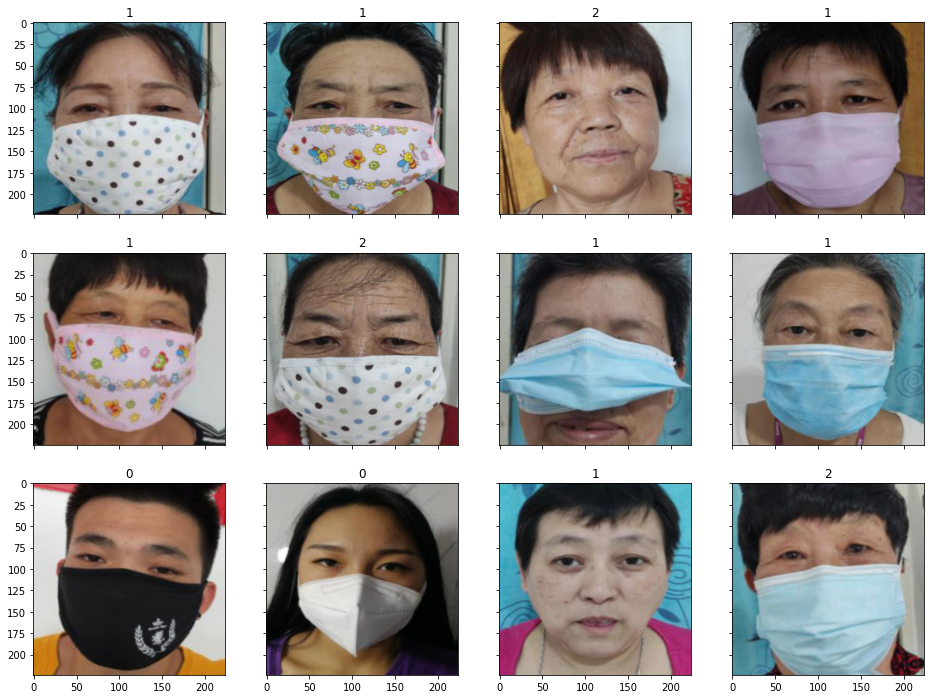

In [20]:
#all_dataset = FaceDataset(path.train_img, transform, range=(0, 2700))

#all_loader = DataLoader(
#    all_dataset,
#    batch_size=12,
#    num_workers=4,
#    shuffle=True
#)

imgs, labels = next(iter(dataloader['age'][0]))
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(16,12))
for i in range(3):
    for j in range(4):
        axes[i][j].imshow(imgs[i * 4 + j])
        axes[i][j].set_title(f'{labels[i * 4 + j]}')

In [36]:
from collections import Counter
from tqdm.notebook import tqdm
mask_label_count = []
for data in tqdm(dataloader['age']):
    for _, labels in tqdm(data):
        mask_label_count += labels.tolist()
mask_label_count = Counter(mask_label_count)
print(mask_label_count)



Counter({0: 8102, 1: 6881, 2: 3052})


In [37]:
import timm
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(0)



In [41]:
def train(model, dataloader, optimizer, scheduler, criterion, name):
    train_log_interval = 5
    batch_size = param.batch_size
    num_epochs = 6
    num_folds = len(dataloader)

    counter = 0
    best_val_acc = 0
    best_val_loss = np.inf
    best_f1_score = 0
    patience = 10

    device = torch.device('cuda')
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()

        loss_value = 0
        matches = 0
        f1_labels = []
        f1_preds = []
        
        train_indices = [i for i in range(num_folds) if i != epoch % num_folds]
        valid_index = epoch % num_folds
        for train_index in train_indices:
            print(train_index + 1, 'th fold training')
            for i, data in enumerate(dataloader[train_index]):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs.permute(0, 3, 1, 2).float())
                preds = torch.argmax(outputs, dim=-1)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                loss_value += loss.item()
                matches += (preds == labels).sum().item()
                f1_labels += [label.item() for label in labels]
                f1_preds += [pred.item() for pred in preds]

                if (i + 1) % train_log_interval == 0:
                    train_loss = loss_value / train_log_interval
                    train_acc = matches / batch_size / train_log_interval
                    f1 = f1_score(f1_labels, f1_preds, average='macro')
                    print(f'{name}) epoch: {epoch + 1}, batch: {i + 1}, train loss: {train_loss:5.3}, train accuracy: {train_acc:5.3%}, f1-score: {f1}')

                    loss_value = 0
                    matches = 0

        model.eval()
        val_loss_items = []
        val_acc_items = []
        f1_labels = []
        f1_preds = []
        with torch.no_grad():
            print("Calculating validation results")
            for val_batch in dataloader[valid_index]:
                inputs, labels = val_batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs.permute(0, 3, 1, 2).float())
                preds = torch.argmax(outputs, dim=-1)

                loss_item = criterion(outputs, labels).item()
                acc_item = (labels == preds).sum().item()
                val_loss_items.append(loss_item)
                val_acc_items.append(acc_item)
                f1_labels += [label.item() for label in labels]
                f1_preds += [pred.item() for pred in preds]

            val_loss = np.sum(val_loss_items) / len(dataloader[valid_index])
            val_acc = np.sum(val_acc_items) / len(dataloader[valid_index]) / batch_size
            f1 = f1_score(f1_labels, f1_preds, average='macro')

            if val_loss < best_val_loss:
                best_val_loss = val_loss
            
            if f1 > best_f1_score:
                print("New best model for f1-score! saving the model")
                save_path = f'results/{name}'
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                torch.save(model.state_dict(), save_path + f'/{epoch:03}_accuracy_{val_acc:4.2%}_f1_{f1:4.2}_imbalanced.ckpt')
                best_val_acc = val_acc
                best_f1_score = f1
                counter = 0
            else:
                counter += 1

            if counter > patience:
                print('Early stopping')
                break

            print('val_acc:', val_acc, 'loss:', val_loss, 'best acc:', best_val_acc, 'best loss:', best_val_loss, 'best f1-score', best_f1_score)
            
            scheduler.step(val_loss)
    print('Finishing Training')

In [42]:
from focal_loss.focal_loss import FocalLoss
lr = 0.0001


model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2)
optimizer = torch.optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
train(model=model, dataloader=dataloader['gender'], optimizer=optimizer, scheduler=scheduler, criterion=criterion, name='Gender')

model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=3)
optimizer = torch.optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
train(model=model, dataloader=dataloader['mask'], optimizer=optimizer, scheduler=scheduler, criterion=criterion, name='Mask')

model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=3)
optimizer = torch.optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
train(model=model, dataloader=dataloader['age'], optimizer=optimizer, scheduler=scheduler, criterion=criterion, name='Age')


Gender) epoch: 2, batch: 30, train loss: 0.0227, train accuracy: 99.375%, f1-score: 0.9742101655354373
Gender) epoch: 2, batch: 35, train loss: 0.0187, train accuracy: 99.062%, f1-score: 0.9748898298144537
Gender) epoch: 2, batch: 40, train loss: 0.0165, train accuracy: 99.062%, f1-score: 0.9755387408382898
Gender) epoch: 2, batch: 45, train loss: 0.00316, train accuracy: 100.000%, f1-score: 0.9764591028563656
Gender) epoch: 2, batch: 50, train loss: 0.00845, train accuracy: 99.375%, f1-score: 0.9770916386822769
Gender) epoch: 2, batch: 55, train loss: 0.00396, train accuracy: 99.688%, f1-score: 0.9778162769064792
5 th fold training
Gender) epoch: 2, batch: 5, train loss: 0.227, train accuracy: 123.125%, f1-score: 0.9775231611737771
Gender) epoch: 2, batch: 10, train loss: 0.0391, train accuracy: 98.438%, f1-score: 0.9778764155799589
Gender) epoch: 2, batch: 15, train loss: 0.0507, train accuracy: 98.750%, f1-score: 0.9783131405054661
Gender) epoch: 2, batch: 20, train loss: 0.034, tr

KeyboardInterrupt: 

In [27]:
from collections import defaultdict
cnt = defaultdict(int)
for q in range(6):
    for i, l in dataloader['age'][q]:
        #print(l)
        for v in l:
            cnt[v.item()] += 1

    print(cnt)


defaultdict(<class 'int'>, {1: 660, 0: 6})
defaultdict(<class 'int'>, {1: 1258, 0: 74})
defaultdict(<class 'int'>, {1: 1347, 0: 443, 2: 208})
defaultdict(<class 'int'>, {1: 1511, 0: 857, 2: 296})
defaultdict(<class 'int'>, {1: 1621, 0: 982, 2: 727})
defaultdict(<class 'int'>, {1: 1856, 0: 1184, 2: 956})


In [23]:
a = [torch.tensor(1)] * 3
print(a.item)

AttributeError: 'list' object has no attribute 'items'